# Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [23]:
train=pd.read_csv("/Users/apple/Desktop/titanic/train.csv")
test=pd.read_csv("/Users/apple/Desktop/titanic/test.csv")

In [24]:
# Cabin
train.loc[~train["Cabin"].isnull(), "Cabin"]=1
train.loc[train["Cabin"].isnull(), "Cabin"]=0

test.loc[~train["Cabin"].isnull(), "Cabin"]=1
test.loc[train["Cabin"].isnull(), "Cabin"]=0

In [25]:
# Sex
train.loc[train["Sex"]=="male", "Sex"]=1
train.loc[train["Sex"]=="female", "Sex"]=0

test.loc[test["Sex"]=="male", "Sex"]=1
test.loc[test["Sex"]=="female", "Sex"]=0

In [26]:
# Name
def title(name):
    x = re.search(',', name).start()
    y = re.search('\.', name).start()
    return name[x+2:y]

train["Title"]=train['Name'].apply(title)
train=train.drop("Name", axis=1)

test["Title"]=test['Name'].apply(title)
test=test.drop("Name", axis=1)

In [27]:
# pd.isna(train_x).sum()
# train_x.describe()

# split
train_y=train.Survived
train_x=train.drop(["PassengerId", "Survived", "Ticket"], axis=1)

test_x=test.drop(["PassengerId", "Ticket"], axis=1)

In [28]:
# data imputation
train_x["Age"]=train_x["Age"].fillna(train_x["Age"].mean())
train_x["Age"]=train_x["Age"].fillna(train_x.Embarked.value_counts().index[0])

test_x["Age"]=test_x["Age"].fillna(test_x["Age"].mean())
test_x["Fare"]=test_x["Fare"].fillna(test_x["Fare"].mean())

# categorical variable
def help1(arg):
    if arg not in ["Mr", "Mrs", "Miss", "Master"]:
        return "Unknown"
    else:
        return arg

train_x.Title=train_x.Title.apply(help1)
test_x.Title=test_x.Title.apply(help1)

train_x=pd.get_dummies(train_x, columns=["Pclass", "Embarked", "Title"])
test_x=pd.get_dummies(test_x, columns=["Pclass", "Embarked", "Title"])

#train_x.Pclass=train_x.Pclass.astype("category")
#train_x.Sex=train_x.Sex.astype("category")
#train_x.Embarked=train_x.Embarked.astype("category")
#train_x.Title=train_x.Title.astype("category")

#test_x.Pclass=test_x.Pclass.astype("category")
#test_x.Sex=test_x.Sex.astype("category")
#test_x.Embarked=test_x.Embarked.astype("category")
#test_x.Title=test_x.Title.astype("category")

In [29]:
# Age
test_x.Age=(test_x.Age-min(train_x.Age))/(max(train_x.Age)-min(train_x.Age))
train_x.Age=(train_x.Age-min(train_x.Age))/(max(train_x.Age)-min(train_x.Age))

In [30]:
# Fare
test_x.Fare=(test_x.Fare-min(train_x.Fare))/(max(train_x.Fare)-min(train_x.Fare))
train_x.Fare=(train_x.Fare-min(train_x.Fare))/(max(train_x.Fare)-min(train_x.Fare))

## SVM

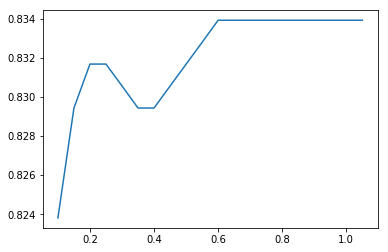

In [35]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

cve=[]
for i in np.arange(0.1, 1.1, 0.05):
    cv_svm = svm.SVC(gamma="scale", C=i)
    scores = cross_val_score(cv_svm, np.asarray(train_x), np.asarray(train_y), cv=5)
    cve.append(np.sum(scores)/len(scores))
    
plt.plot(np.arange(0.1, 1.1, 0.05), cve)

In [36]:
svm_classifier=svm.SVC(gamma="scale", C=0.6)
svm_classifier.fit(np.asarray(train_x), np.asarray(train_y))

svm_pred=svm_classifier.predict(np.asarray(test_x))
np.savetxt("foo_svm.csv", svm_pred, delimiter=",")

## LR

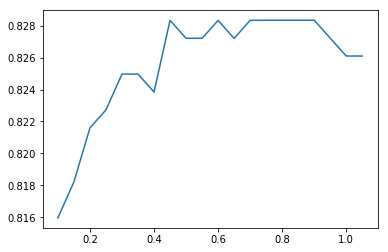

In [42]:
from sklearn.linear_model import LogisticRegression

cve=[]
for i in np.arange(0.1, 1.1, 0.05):
    cv_lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=500, C=i)
    scores = cross_val_score(cv_lr, np.asarray(train_x), np.asarray(train_y), cv=5)
    cve.append(np.sum(scores)/len(scores))
    
plt.plot(np.arange(0.1, 1.1, 0.05), cve)

In [43]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=500, C=0.7)
lr.fit(np.asarray(train_x), np.asarray(train_y))

lr_pred=lr.predict(test_x)
np.savetxt("foo_lr.csv", lr_pred, delimiter=",")

## DT

In [50]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(np.asarray(train_x), np.asarray(train_y))

dt_pred=dt.predict(np.asarray(test_x))
np.savetxt("foo_dt.csv", dt_pred, delimiter=",")

## RF

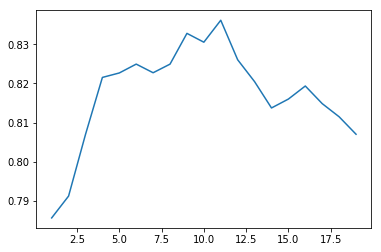

In [45]:
from sklearn.ensemble import RandomForestClassifier

cve=[]
for i in np.arange(1, 20, 1):
    cv_rf = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    scores = cross_val_score(cv_rf, np.asarray(train_x), np.asarray(train_y), cv=5)
    cve.append(np.sum(scores)/len(scores))

plt.plot(np.arange(1, 20, 1), cve)

In [46]:
rf = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=0)
rf.fit(np.asarray(train_x), np.asarray(train_y))

rf_pred=rf.predict(np.asarray(test_x))
np.savetxt("foo_rf.csv", rf_pred, delimiter=",")

## AdaBoost

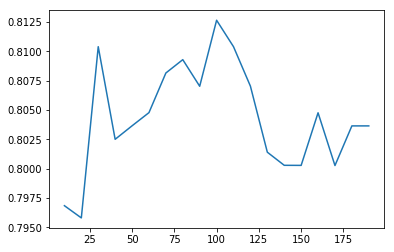

In [57]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

cve=[]
for i in np.arange(10, 200, 10):
    base=tree.DecisionTreeClassifier(max_depth=9)
    cv_ada = AdaBoostClassifier(n_estimators=i, base_estimator=base, random_state=0)
    scores = cross_val_score(cv_ada, np.asarray(train_x), np.asarray(train_y), cv=5)
    cve.append(np.sum(scores)/len(scores))

plt.plot(np.arange(10, 200, 10), cve)

In [58]:
ada = AdaBoostClassifier(n_estimators=100, base_estimator=tree.DecisionTreeClassifier(max_depth=9), random_state=0)
ada.fit(np.asarray(train_x), np.asarray(train_y))

ada_pred=ada.predict(np.asarray(test_x))
np.savetxt("foo_ada.csv", ada_pred, delimiter=",")

## GB

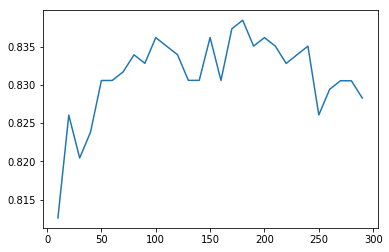

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

cve=[]
for i in np.arange(10, 300, 10):
    cv_gb = GradientBoostingClassifier(n_estimators=i, max_depth=4, random_state=0)
    scores = cross_val_score(cv_gb, np.asarray(train_x), np.asarray(train_y), cv=5)
    cve.append(np.sum(scores)/len(scores))

plt.plot(np.arange(10, 300, 10), cve)

In [64]:
gb = GradientBoostingClassifier(n_estimators=180, max_depth=4, random_state=0)
gb.fit(np.asarray(train_x), np.asarray(train_y))

gb_pred=gb.predict(np.asarray(test_x))
np.savetxt("foo_gb.csv", gb_pred, delimiter=",")

## Stacking & DNN

In [ ]:
import t